In [1]:
import os.path
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import yt
import glob
import pandas as pd
import math
import scipy.integrate as integrate
from matplotlib.backends.backend_pdf import PdfPages
mpl.rcParams['figure.dpi'] = 300

/home/dbeckers/.conda/envs/postprocessing/lib/python3.7/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [8]:
t_final = 0.5
Lx = 2.0
u0 = 1.0
v0 = 0.0
alpha = 8*math.pi
beta = 8*math.pi
A = 1/(8*math.pi)
nu = 0.001

In [9]:
def UExact(x,y,t,u0,v0,alpha,beta,A,nu):
    u = u0 - A * beta * math.cos(alpha * (x - u0 * t)) * math.sin(beta * (y - v0 * t)) * math.exp(-(alpha ** 2 + beta ** 2) * nu * t);
    return u


In [10]:
def VExact(x,y,t,u0,v0,alpha,beta,A,nu):
    v = v0 + A * alpha * math.sin(alpha * (x - u0 * t)) * math.cos(beta * (y - v0 * t)) * math.exp(-(alpha ** 2 + beta ** 2) * nu * t);
    return v


In [11]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

In [12]:
root_dir = '/home/dbeckers/tests/ctv'

In [15]:
# methods = ['godunov_ppm','godunov_weno_z','mol_central']
# methods = ['godunov_ppm','godunov_ppm_nonFV']
# methods = ['godunov_ppm','mol_central']
methods = ['godunov_ppm']
# methods = ['godunov_weno_z']
# methods = ['mol_central']
# methods = ['godunov_ppm','godunov_weno_z']
# methods = ['mol_central','periodic_mol_central']

grid_types = ['uniform']
# grid_types = ['uniform','fine_to_coarse']
# grid_types = ['fine_to_coarse']
# grid_types = ['uniform_modulated']
# grid_types = ['fine_to_coarse_modulated']
grid_sizes = [int(64*2**i) for i in range(1)]
wave_number = "8pi"

dx_list = [Lx/grid_size for grid_size in grid_sizes]
print(grid_sizes)
color_list = [
    "#EE2E2F",
    "#008C48",
    "#185AA9",
    "#F47D23",
    "#662C91",
    "#A21D21",
    "#B43894",
    "#010202",
]
linestyle_list = [
    "solid",
    "dashed",
    "dotted",
    "dashdot"
]
linewidth_list = [
    1.5,
    0.5
]

[64]


In [16]:
# fields = ["x","y","p"]
fields = ["x","y","z","velocityy"]

In [24]:
error_lists = [[[] for j in range(len(grid_types))] for i in range(len(methods))]
df_lists = [[[[] for k in range(len(grid_sizes))] for j in range(len(grid_types))] for i in range(len(methods))]

i_method = -1
for method in methods:
    i_method += 1
    i_grid_type = -1
    for grid_type in grid_types:
        i_grid_type += 1
        i_grid_size = -1
        for grid_size in grid_sizes:
            i_grid_size += 1

            case_dir = os.path.join(root_dir, method, grid_type, wave_number,f'nx_{grid_size}')
            
            # Load plt files
            plt_files = natural_sort(glob.glob(os.path.join(case_dir, "plt*")))
            
            for idx in range(len(plt_files)):
            
                ds = yt.load(plt_files[idx])
                ray = ds.r[0:,1,0]
                srt = np.argsort(ray["x"])
                df = pd.DataFrame({f: np.array(ray[f][srt]) for f in fields})
                t = ds.current_time.value.flatten()[0]
                df["time"] = t
                df["dx"] = [ray.fwidth[i][0].value.flatten()[0] for i in range(len(df["x"].values))]

                df_lists[i_method][i_grid_type][i_grid_size].append(df)
                
            # Plot error
            error_file = os.path.join(case_dir,'ctv.log')
            with open(error_file) as f:
                lines = f.readlines()
                time = [float(line.split()[0]) for line in lines[1:]]
                u_error = [float(line.split()[1]) for line in lines[1:]]
                v_error = [float(line.split()[2]) for line in lines[1:]]
            data={'time':time,'u_error':u_error,'v_error':v_error}
            error_lists[i_method][i_grid_type].append(pd.DataFrame(data)) 


yt : [INFO     ] 2022-08-05 15:52:09,291 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-05 15:52:09,291 Parameters: domain_dimensions         = [64 64  1]
yt : [INFO     ] 2022-08-05 15:52:09,292 Parameters: domain_left_edge          = [ 0.        0.       -0.015625]
yt : [INFO     ] 2022-08-05 15:52:09,293 Parameters: domain_right_edge         = [2.       2.       0.015625]
yt : [INFO     ] 2022-08-05 15:52:09,636 Parameters: current_time              = 0.0625
yt : [INFO     ] 2022-08-05 15:52:09,637 Parameters: domain_dimensions         = [64 64  1]
yt : [INFO     ] 2022-08-05 15:52:09,638 Parameters: domain_left_edge          = [ 0.        0.       -0.015625]
yt : [INFO     ] 2022-08-05 15:52:09,639 Parameters: domain_right_edge         = [2.       2.       0.015625]
yt : [INFO     ] 2022-08-05 15:52:09,978 Parameters: current_time              = 0.125
yt : [INFO     ] 2022-08-05 15:52:09,979 Parameters: domain_dimensions         = [64 64  1]
yt : [INFO     ] 2

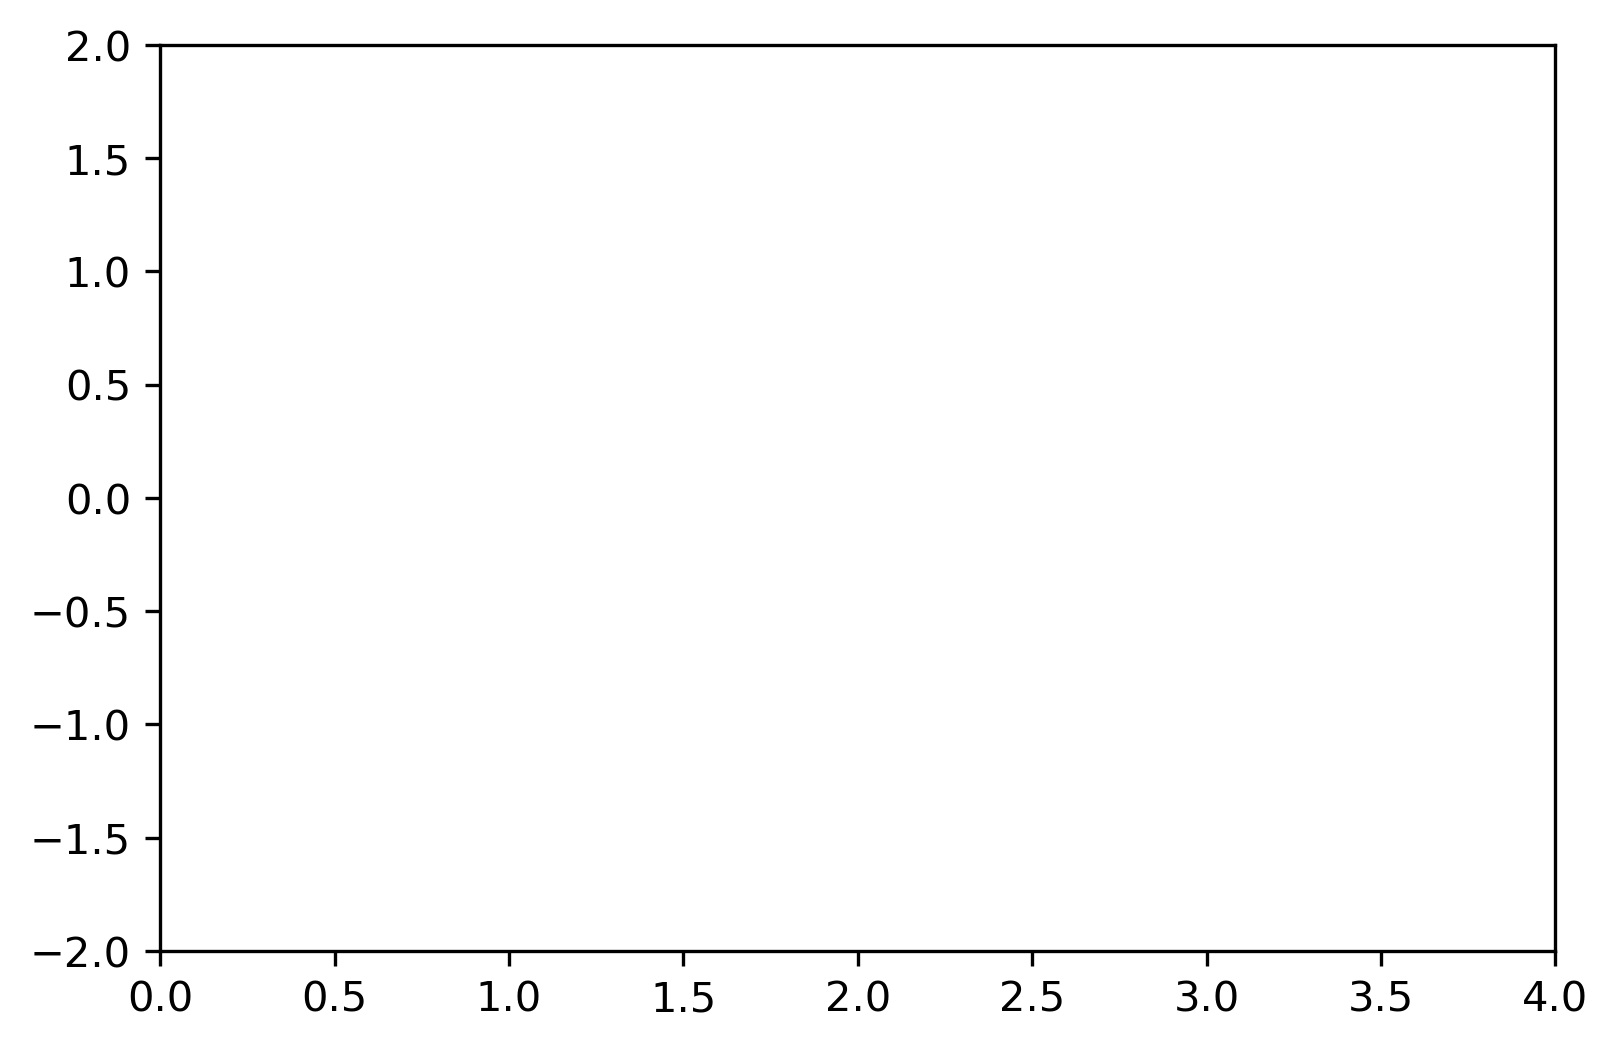

In [33]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 4), ylim=(-2, 2))
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    x = np.linspace(0, 4, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

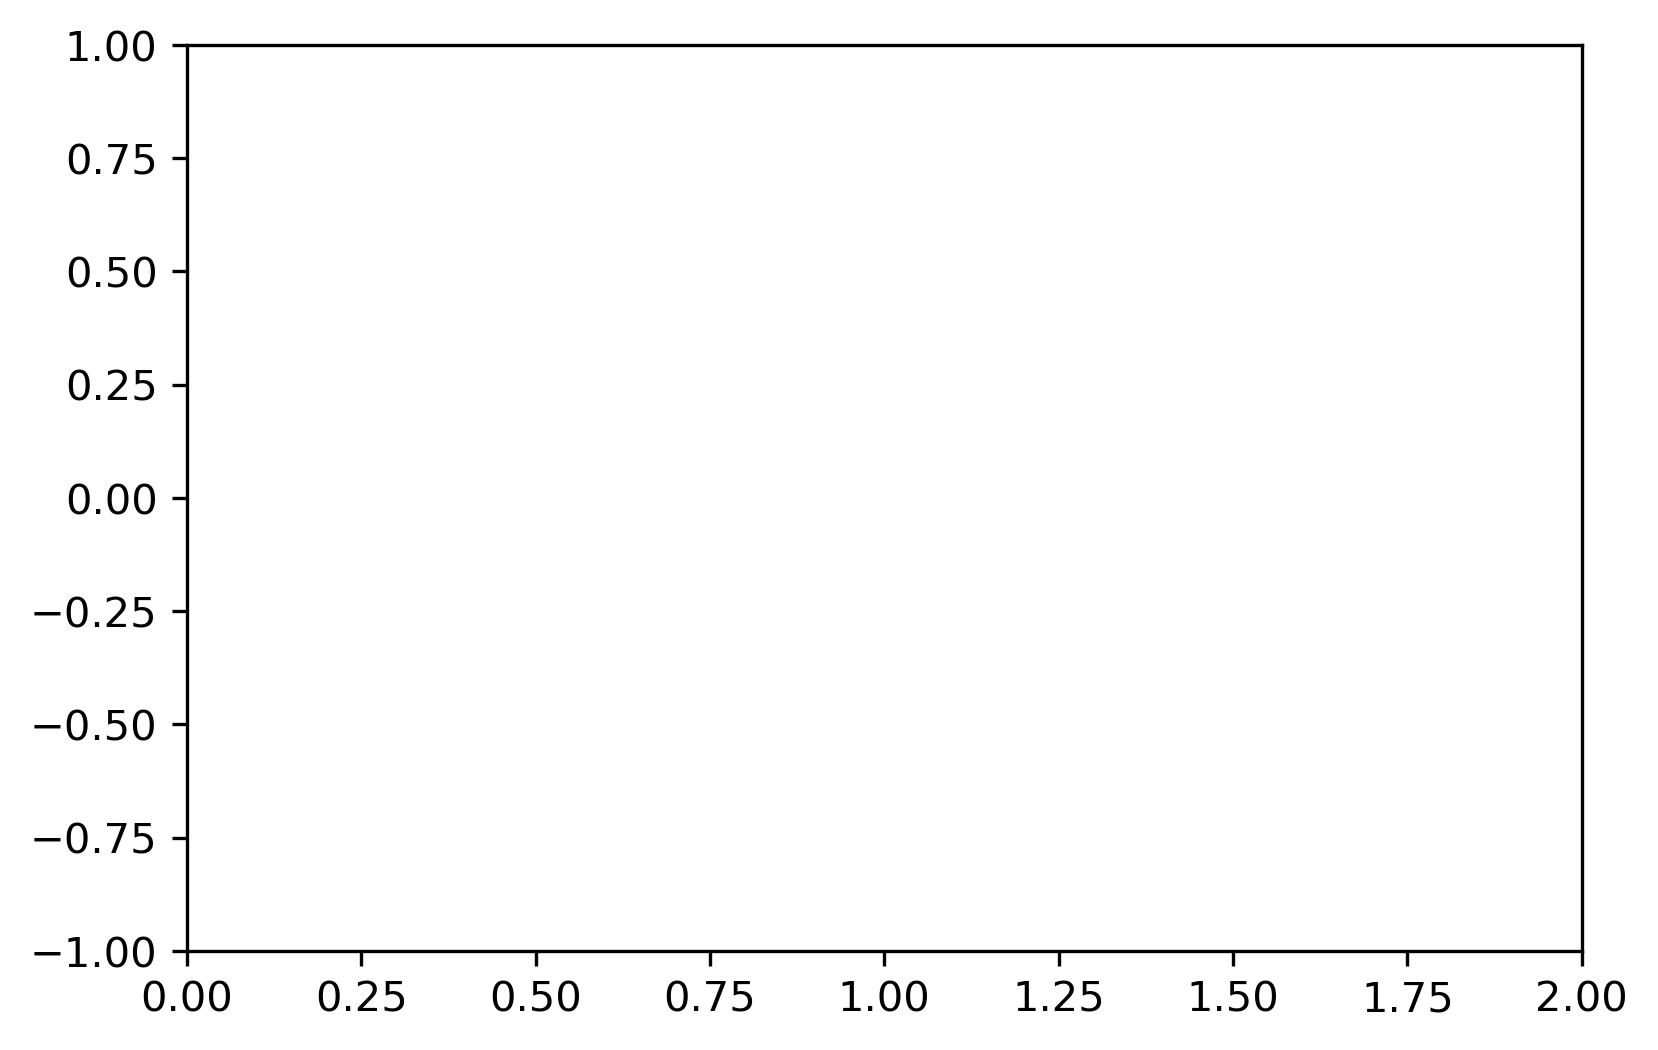

In [32]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-1, 1))
line, = ax.plot([], [])

def init():
    line.set_data([], [])
    return line,
def animate(i):
    df = df_lists[0][0][0][i]
    x = df["x"].values
    y = df["velocityy"].values
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=len(df_lists[0][0][0]), interval=1, blit=True)

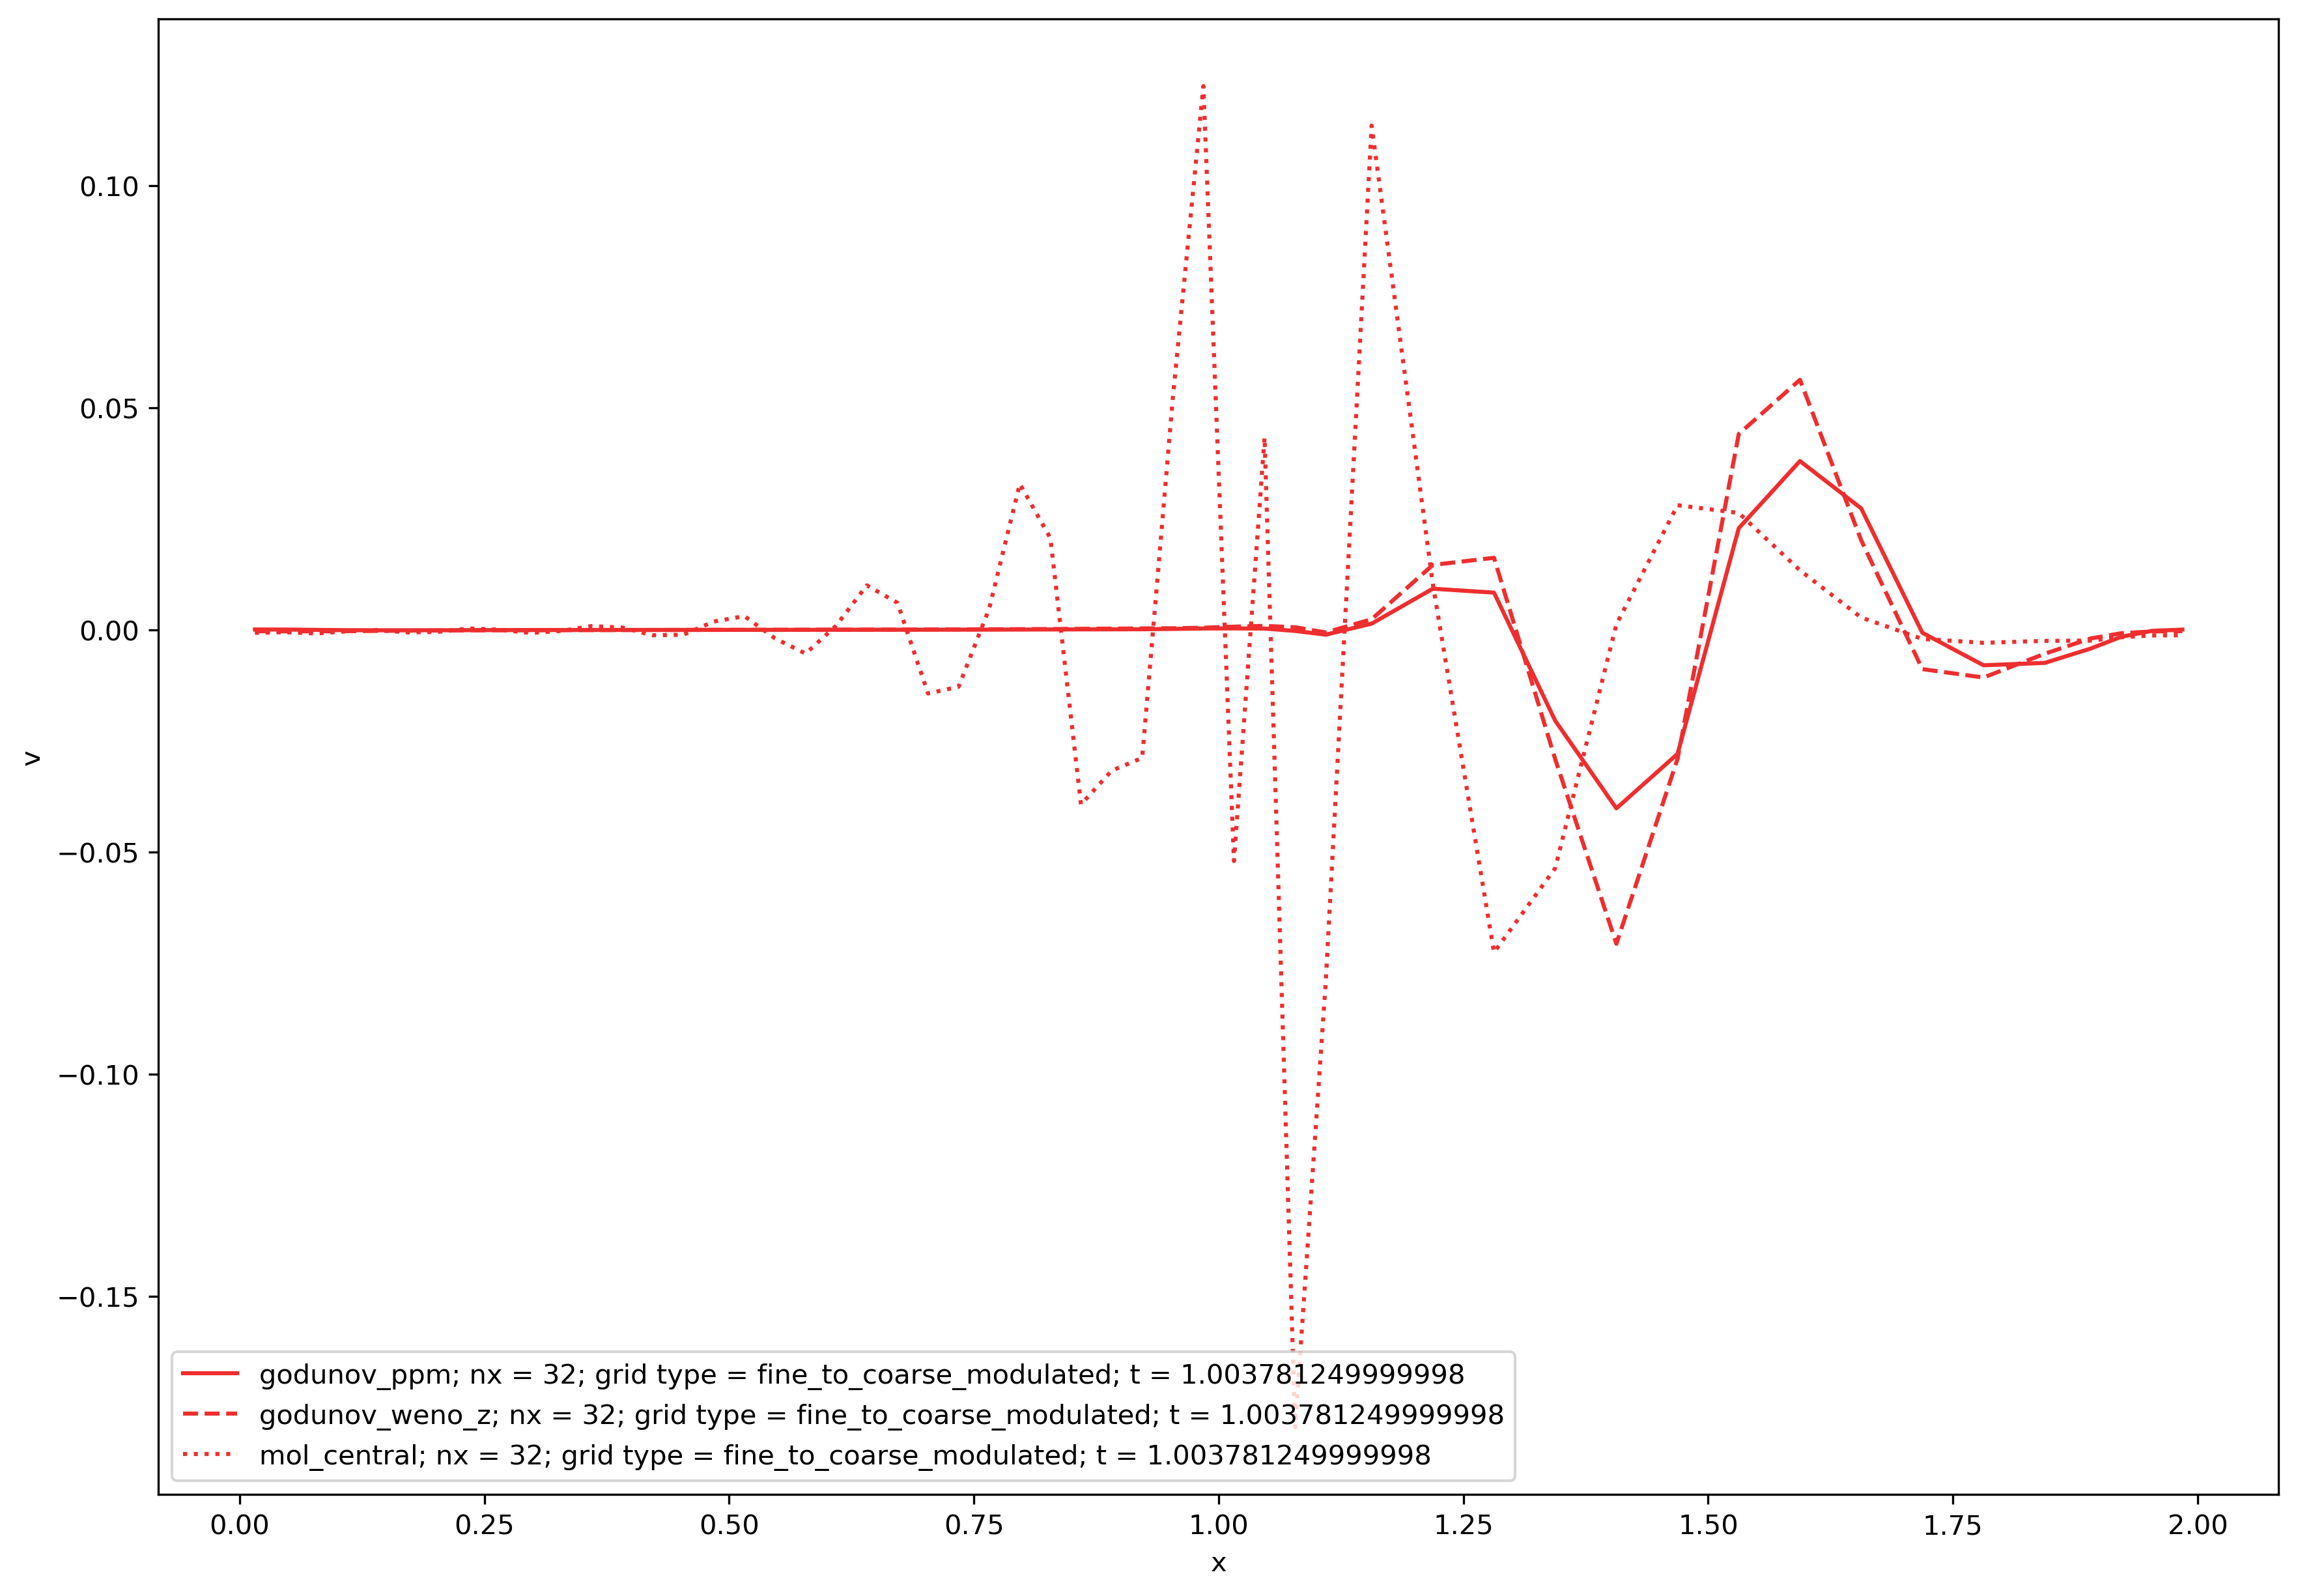

In [420]:
ax2.set_xlabel('x')
ax2.set_ylabel('v')
ax2.set_title('')
ax2.legend()
fig2

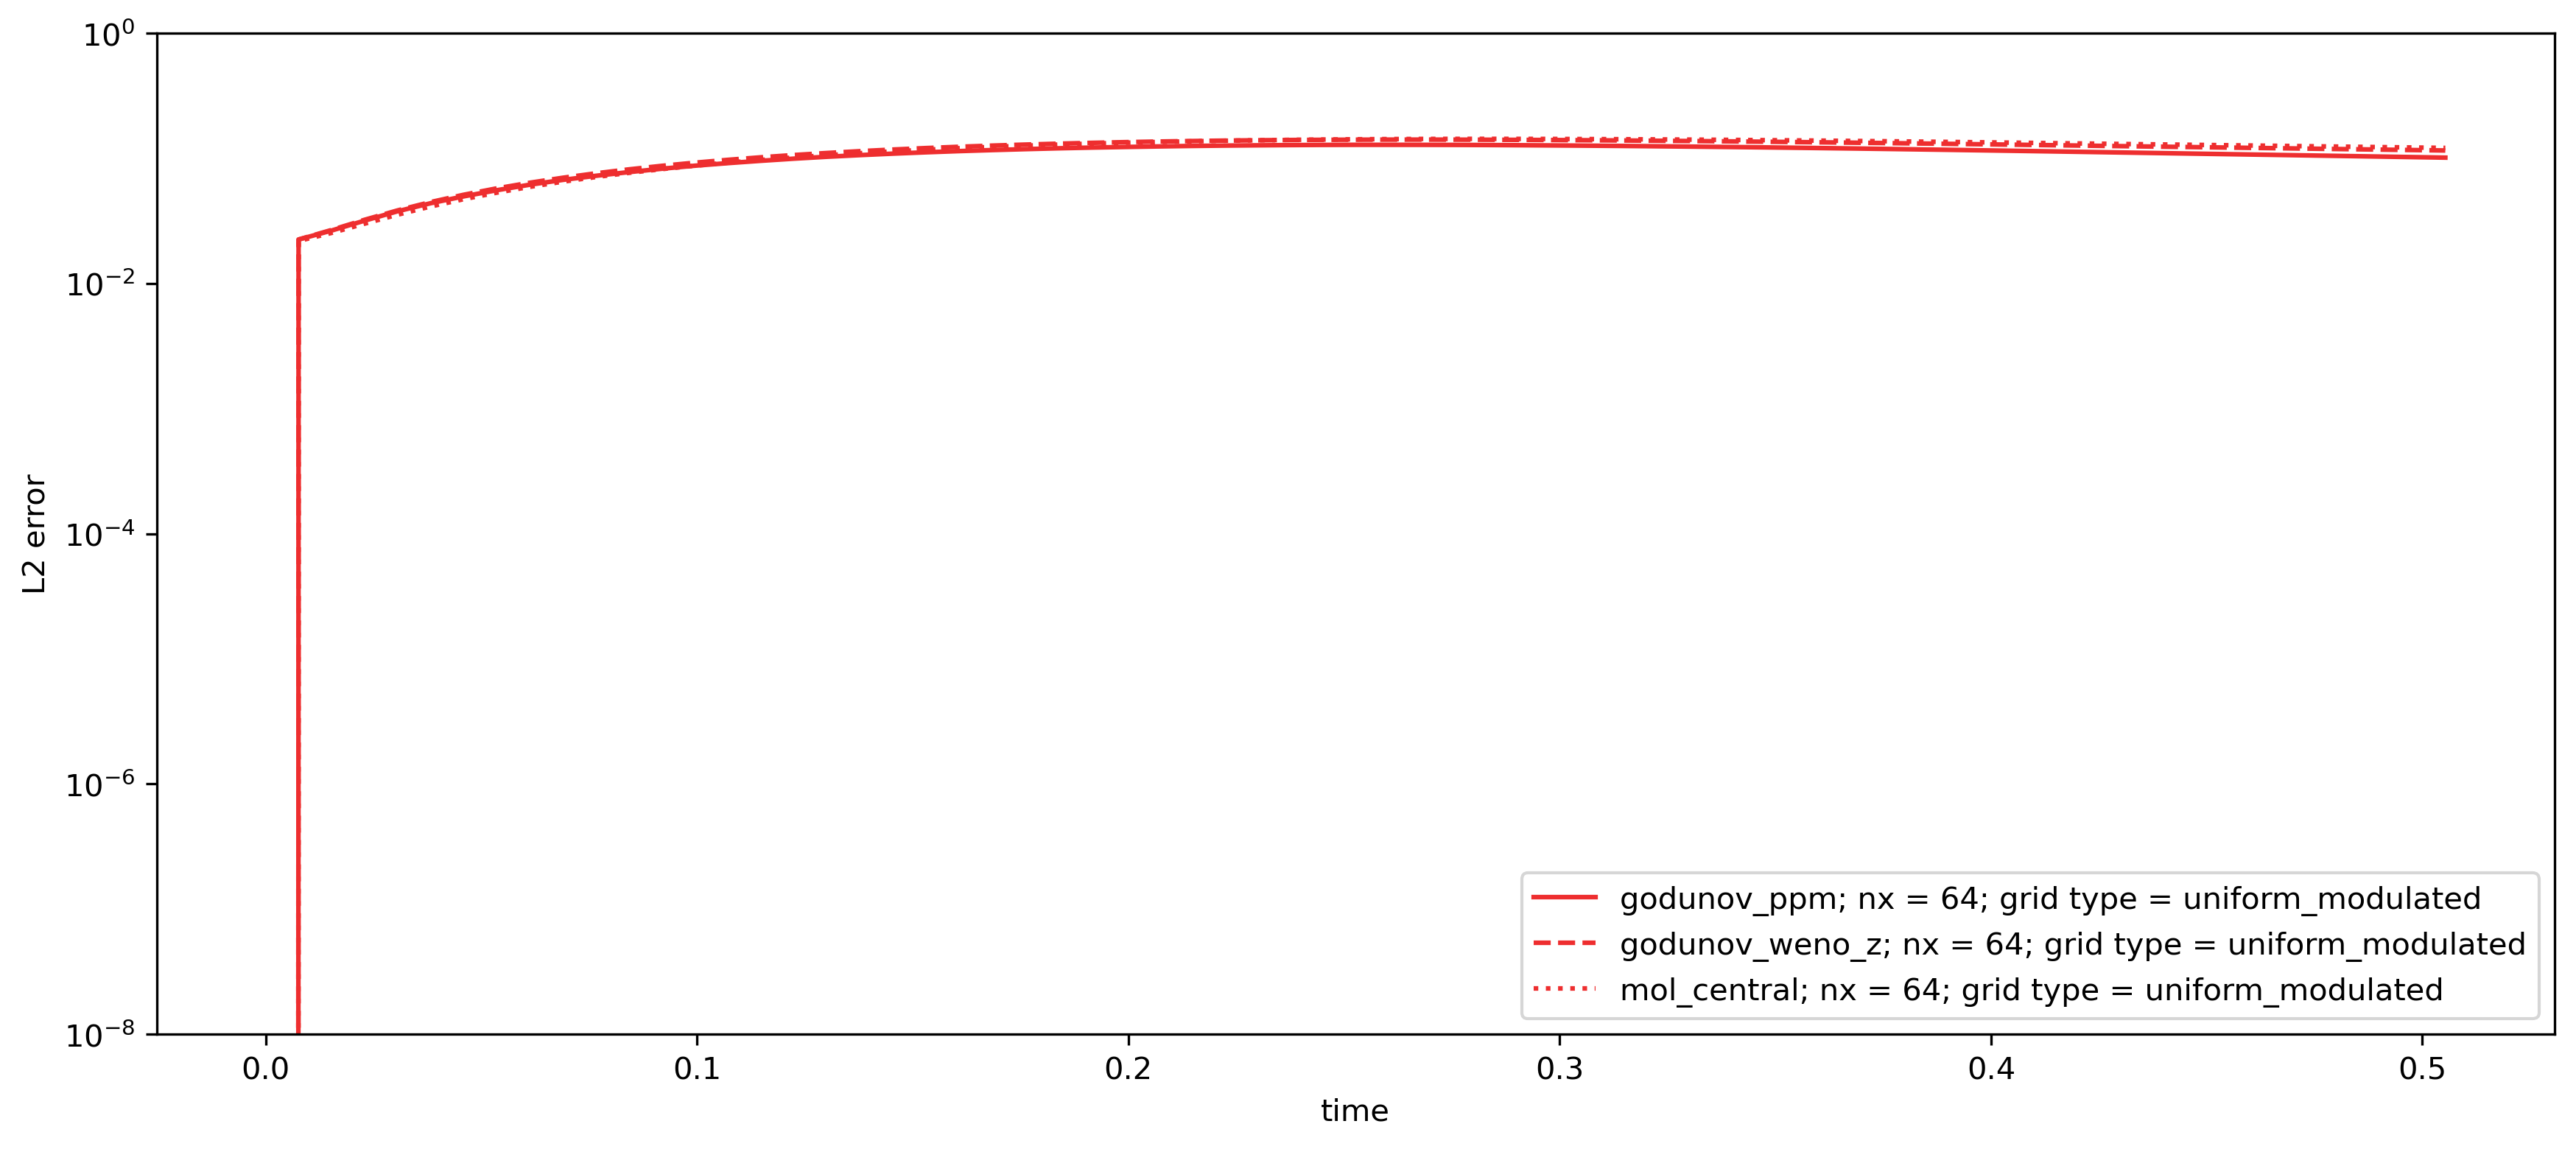

In [334]:
ax1.set_xlabel('time')
ax1.set_ylabel('L2 error')
ax1.set_title('')
ax1.legend()
ax1.set_yscale('log')
ax1.set_ylim([1e-8,1])
fig1

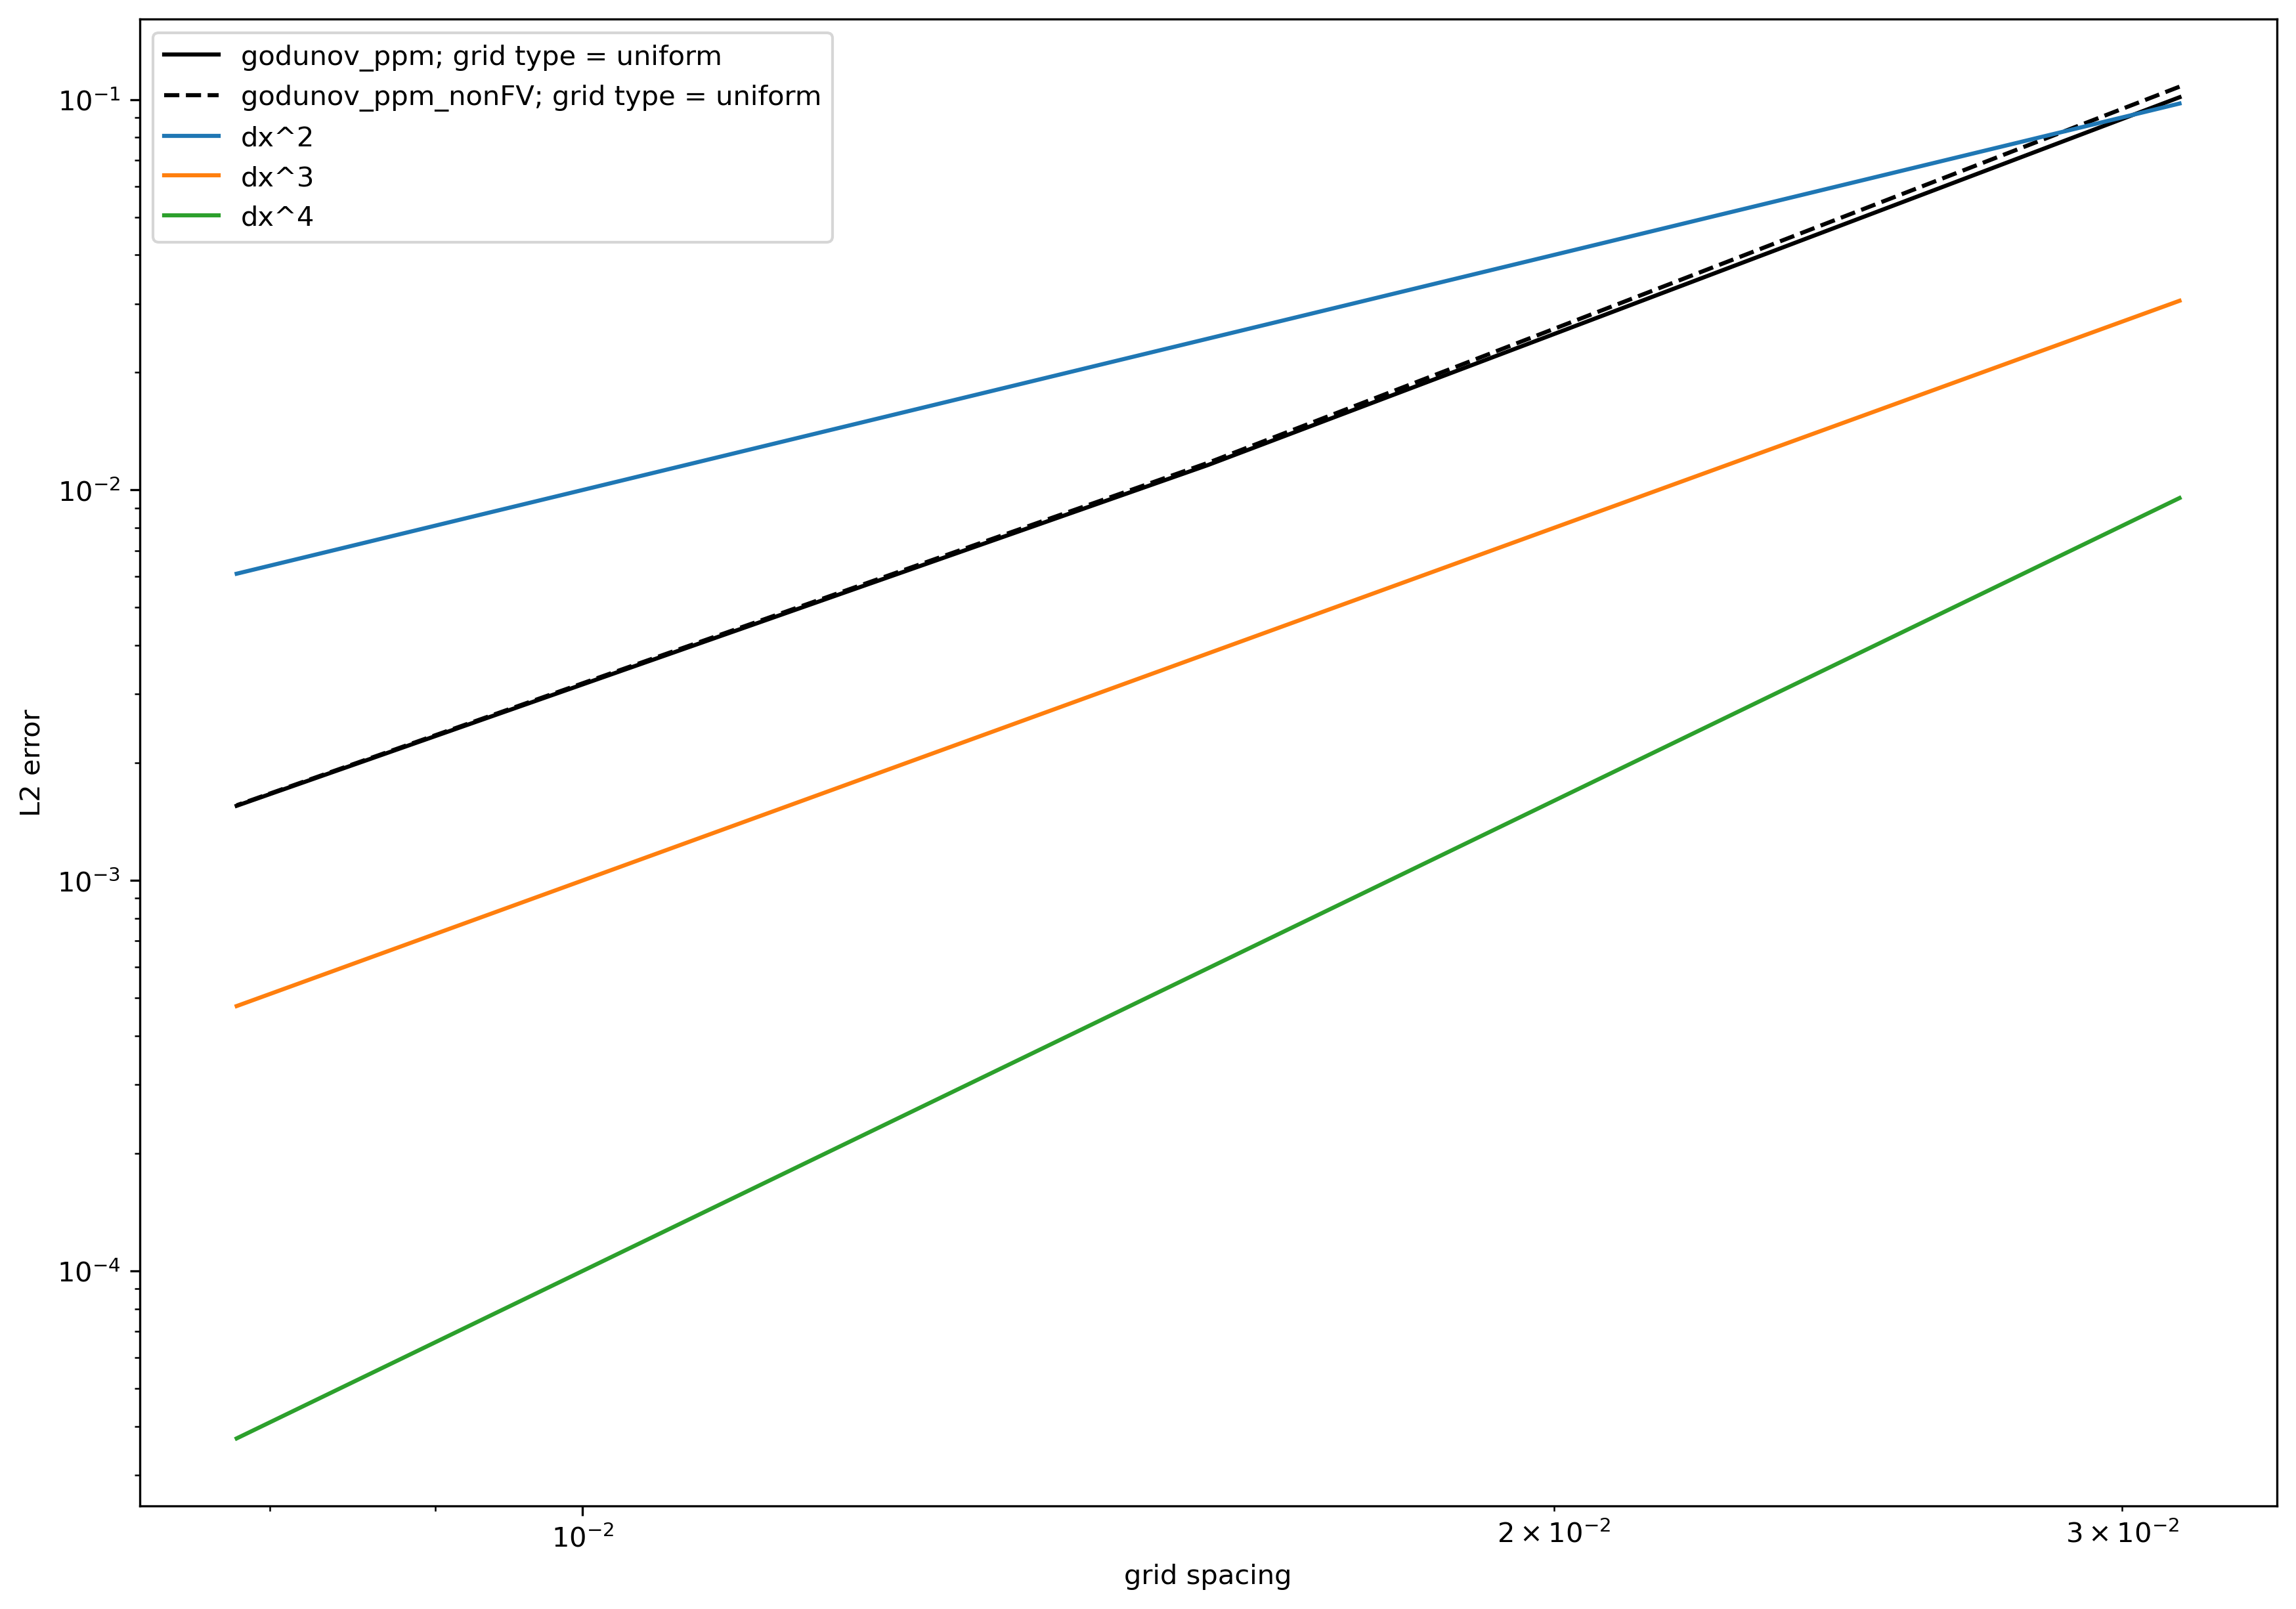

In [298]:
ax3.set_xlabel('grid spacing')
ax3.set_ylabel('L2 error')
ax3.set_title('')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.legend()

# ax3.set_ylim([1e-4,1])
fig3

yt : [INFO     ] 2022-08-05 13:47:33,807 xlim = 0.000000 2.000000
yt : [INFO     ] 2022-08-05 13:47:33,807 ylim = 0.000000 2.000000
yt : [INFO     ] 2022-08-05 13:47:33,808 xlim = 0.000000 2.000000
yt : [INFO     ] 2022-08-05 13:47:33,809 ylim = 0.000000 2.000000
yt : [INFO     ] 2022-08-05 13:47:33,810 Making a fixed resolution buffer of (('boxlib', 'velocityy')) 800 by 800
yt : [WARNING  ] 2022-08-05 13:47:33,955 Plot image for field ('boxlib', 'velocityy') has both positive and negative values. Min = -0.793759, Max = 0.793759.
yt : [WARNING  ] 2022-08-05 13:47:33,956 Switching to symlog colorbar scaling unless linear scaling is specified later
/home/dbeckers/.conda/envs/postprocessing/lib/python3.7/site-packages/yt/visualization/base_plot_types.py:222: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  vmax=float(np.nanmax(data)))
/home/dbeckers/.conda/envs/postprocessing/lib/python3.7/_collec


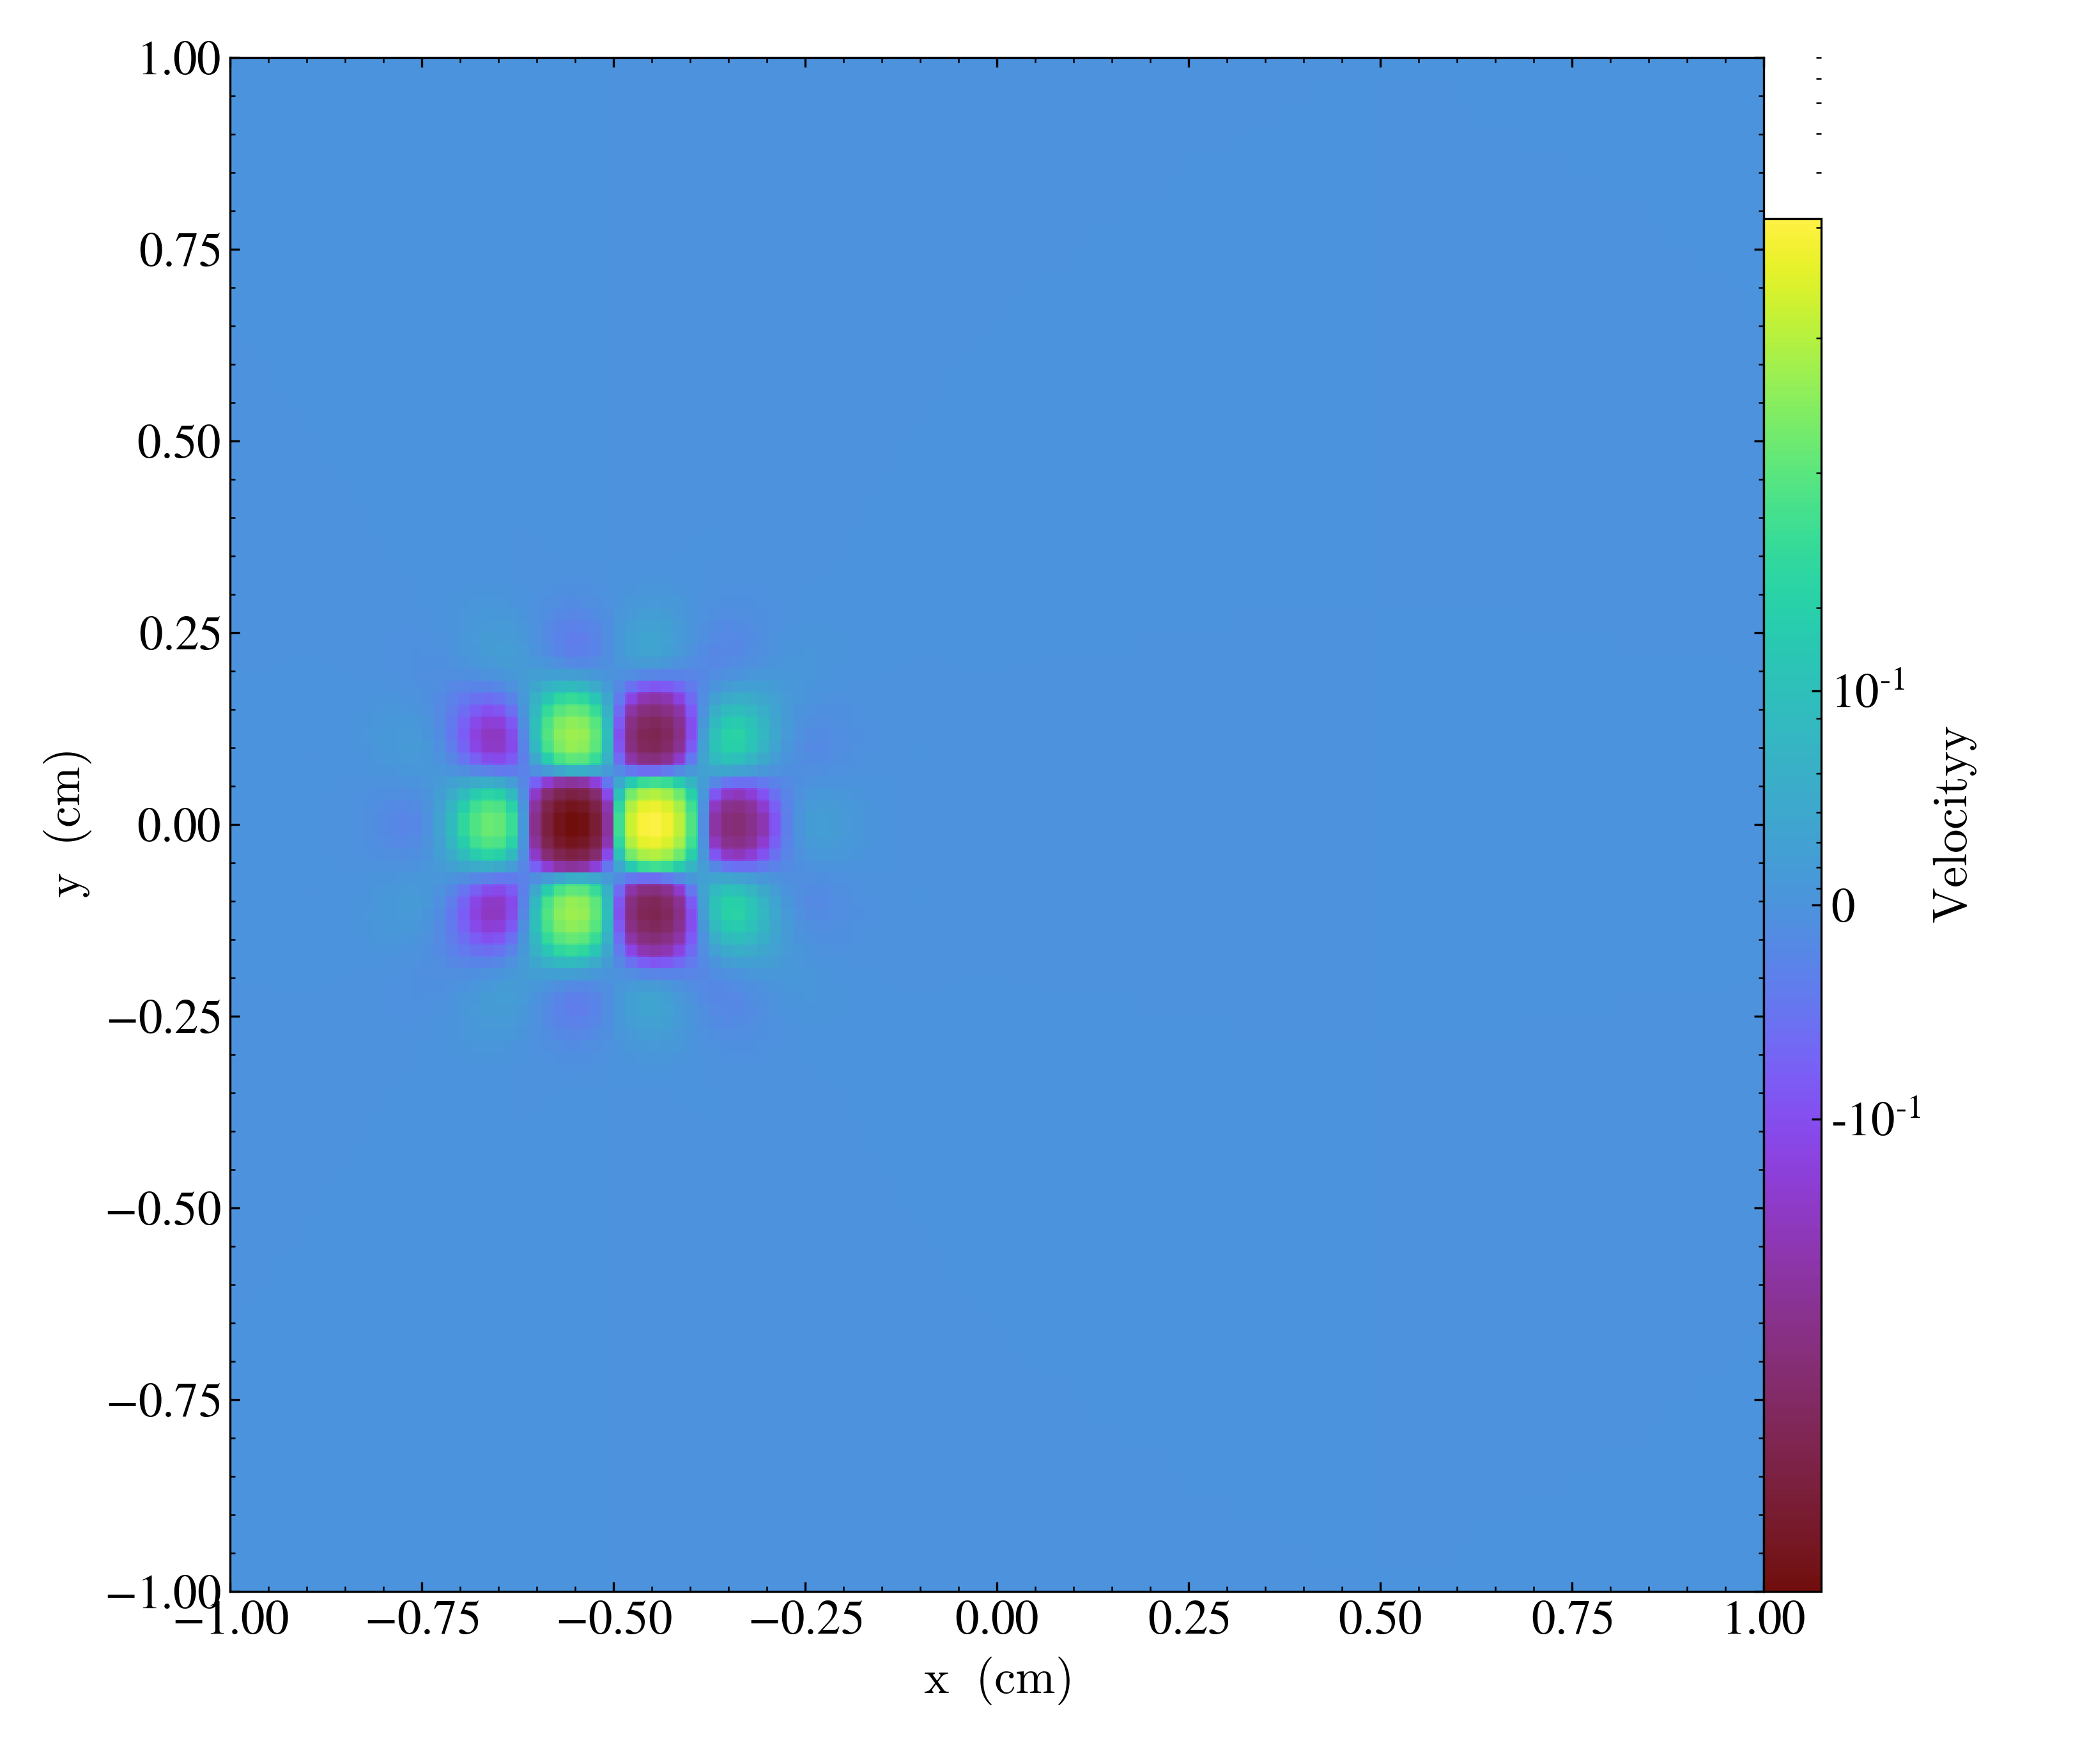

In [398]:
sliceplot = yt.SlicePlot(ds, "z", ("velocityy")).show()